In [1]:
import cmocean as cmo
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from netCDF4 import Dataset
from xmitgcm import open_mdsdataset
import time
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def create_nc_file(dist_array, freq_array, psd_data, phase_data, filename,
                   title, description, units1='PSD', units2='rad', 
                   name1='ssh PSD', name2='phase'):
    
    """ This function creates a netCDF4 file for
    the curtain plot data given the filename. 
    
    :arg dist_array: np 2D array, distance from bay array from meshgrid
    :arg frq_array: np 2D array, frequency array from spectra
    :arg PSD_data: np 2D array of PDS spectra of curtain data. Size is (len(dist_array),len(freq_array))
    :arg PSD_data: np 2D array of phase spectra of curtain data. Size is (len(dist_array),len(freq_array))
    :arg filename: str, Directory and name of netcdf file
    :arg title: str, title of plot
    :arg description: str, Details about the data
    :arg units1: str, Units of PSD data
    :arg units2: str, Units of phase data
    :arg name1: str, name of var 1 (PSD)
    :arg name2: str, name or var 2 (phase)
    
    """
    dataset = Dataset(filename, 'w')
    file_x = dataset.createDimension('x', dist_array.shape[0])
    file_t = dataset.createDimension('freq', freq_array.shape[0])

    file_X = dataset.createVariable('X', 'f8', ('x'))
    file_T = dataset.createVariable('Freq', 'f8', ('freq'))
    amp_data = dataset.createVariable('psd_data', 'f8', ('x','freq'))
    pha_data = dataset.createVariable('phase_data', 'f8', ('x','freq'))

    dataset.title = title
    dataset.author = 'Karina Ramos Musalem'
    dataset.institution = 'ICACC-UNAM'
    dataset.source = '/notebooks/MITgcm/domain5/spectra_curtain_data_bottDrag.ipynb'
    dataset.description = description
    dataset.timeStamp = time.ctime(time.time())
    file_X.standard_name = 'Distance along the coast from SVB'
    file_X.units = 'km'
    file_T.standard_name = 'frequency'
    file_T.units = 'cpd'
    amp_data.standard_name = name1
    amp_data.units = units1
    pha_data.standard_name = name2
    pha_data.units = units2
    
    file_X[:] = dist_array[:]
    file_T[:] = freq_array[:]
    amp_data[:] = psd_data[:]
    pha_data[:] = phase_data[:]

    dataset.close()

In [3]:
## Load ssh curtain data    
SVB = xr.open_dataset('curtain_SSH_SVB_bottDrag.nc')
noSVB = xr.open_dataset('curtain_SSH_NoSVB_bottDrag.nc')

X = SVB.X[:] 
t = SVB.T[:] # in sec

nx = len(X[:])
ny = int(len(t[:])/2)+1

psd = np.zeros((nx,ny))*np.nan
phase = np.zeros((nx,ny))*np.nan

t0 = 0
dt = 600 # 10 min 
freq = (1./dt)

ssh_anom = (SVB.curtain_data.data-noSVB.curtain_data.data)*100 

for ii in range(nx): #nx
    signalFFT = np.fft.rfft(ssh_anom[:,ii])
    
    ## Get Power Spectral Density
    signalPSD = np.abs(signalFFT) ** 2
    #signalPSD /= len(signalFFT)**2

    ## Get Phase
    signalPhase = np.angle(signalFFT)

    ## Get frequencies corresponding to signal 
    fftFreq = np.fft.rfftfreq(len(ssh_anom[:,ii]), dt)

    psd[ii,:] = signalPSD[:]
    phase[ii,:] = signalPhase[:]

In [4]:
psd_sig = np.zeros((nx,ny))*np.nan

t0 = 0
dt = 600 # 10 min 
freq = (1./dt)

for ii in range(nx): #nx
    
    f, Pxx_den = signal.periodogram(ssh_anom[:,ii], freq)

    psd_sig[ii,:] = Pxx_den[:]


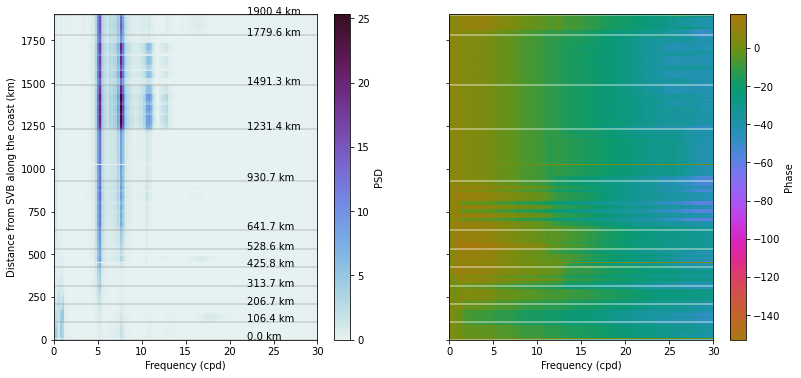

In [5]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(13,6), sharey=True, sharex=True)

ax1.set_xlabel('Frequency (cpd)')
ax1.set_ylabel('Distance from SVB along the coast (km)')
pc1 = ax1.pcolormesh(fftFreq*86400,X, psd, cmap=cmo.cm.dense)
plt.colorbar(pc1,ax=ax1, label='PSD')

ax2.set_xlabel('Frequency (cpd)')
pc2 = ax2.pcolormesh(fftFreq*86400,X, np.unwrap(phase+np.pi), cmap=cmo.cm.phase)
plt.colorbar(pc2,ax=ax2, label='Phase')
ax2.set_xlim(0,30)

for kk in range(nx):
    if kk%50 == 0:
        ax1.axhline(X[kk],color='0.5',alpha=0.3)
        ax1.text(22,X[kk],'%1.1f km' %X[kk], fontsize=10)
        ax2.axhline(X[kk],color='w',alpha=0.5)



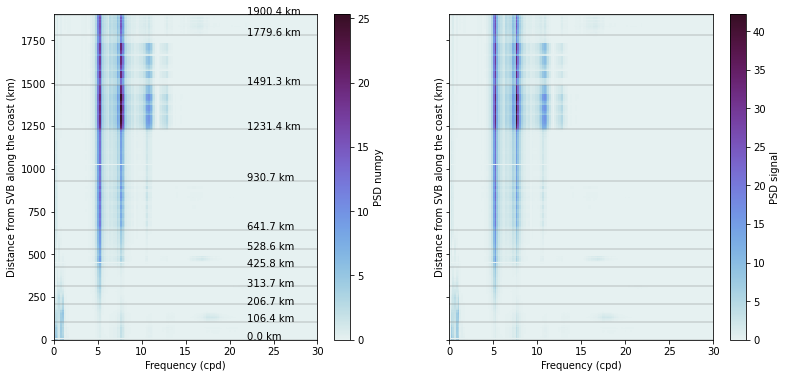

In [6]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(13,6), sharey=True, sharex=True)


ax1.set_xlabel('Frequency (cpd)')
ax1.set_ylabel('Distance from SVB along the coast (km)')
pc1 = ax1.pcolormesh(fftFreq*86400,X, psd, cmap=cmo.cm.dense)
plt.colorbar(pc1,ax=ax1, label='PSD numpy')

ax2.set_xlabel('Frequency (cpd)')
ax2.set_ylabel('Distance from SVB along the coast (km)')
pc2 = ax2.pcolormesh(f*86400,X, psd_sig, cmap=cmo.cm.dense)
plt.colorbar(pc2,ax=ax2, label='PSD signal')

ax1.set_xlim(0,30)

for kk in range(nx):
    if kk%50 == 0:
        ax1.axhline(X[kk],color='0.5',alpha=0.3)
        ax1.text(22,X[kk],'%1.1f km' %X[kk], fontsize=10)
        ax2.axhline(X[kk],color='0.5',alpha=0.3)
       


In [8]:
filename = 'curtain_SSH_spectra_bottDrag.nc'
description = 'spectra of SSH data at points along the coast to build curtain hovmöller plot'
title = 'spectra of SSH curtain plot data bottDrag SVB'

create_nc_file(X, f*86400, psd_sig, phase+np.pi, filename,
               title, description)

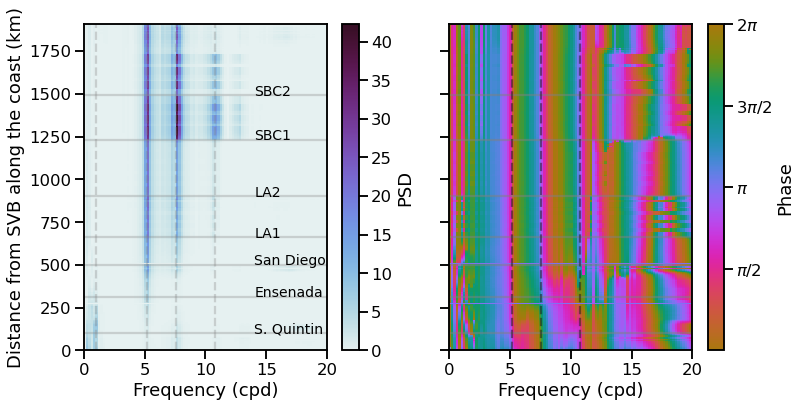

In [9]:
# Check what I saved

sns.set_context('talk')
spec_data = xr.open_dataset('curtain_SSH_spectra_bottDrag.nc')
X2 = spec_data.X
freq2 = spec_data.Freq
psd2 = spec_data.psd_data
phase2 = spec_data.phase_data

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)

ax1.set_xlabel('Frequency (cpd)')
ax1.set_ylabel('Distance from SVB along the coast (km)')
pc1 = ax1.pcolormesh(freq2,X2,psd2, cmap=cmo.cm.dense)
plt.colorbar(pc1,ax=ax1, label='PSD')

ax2.set_xlabel('Frequency (cpd)')
pc2 = ax2.pcolormesh(freq2,X2,phase2, cmap=cmo.cm.phase)
cbar = plt.colorbar(pc2, ax=ax2, label='Phase', ticks=[0,np.pi/2,np.pi,3*np.pi/2,2*np.pi])
cbar.ax.set_yticklabels(['0',r'$\pi/2$', '$\pi$', '$3\pi/2$','$2\pi$'])  


ax2.set_xlim(0,20)

for km, lab in zip([101,313.7,500, 660, 900, 1231, 1492], ['S. Quintin','Ensenada','San Diego','LA1','LA2','SBC1', 'SBC2']):
    ax1.axhline(km,color='0.5',alpha=0.3)
    ax1.text(14,km,lab, fontsize=14)
    ax2.axhline(km,color='0.5',alpha=0.5)

ax1.axvline(5.2, color='0.5', linestyle='--',alpha=0.3)
ax1.axvline(7.6, color='0.5', linestyle='--',alpha=0.3)
ax1.axvline(10.8, color='0.5', linestyle='--',alpha=0.3)
ax1.axvline(1, color='0.5', linestyle='--',alpha=0.3)

ax2.axvline(5.2, color='0.1', linestyle='--',alpha=0.5)
ax2.axvline(7.6, color='0.1', linestyle='--',alpha=0.5)
ax2.axvline(10.8, color='0.1', linestyle='--',alpha=0.5)


In [10]:
# Resolution in frequency:

(np.max(f)-np.min(f))/len(f)

2.3084025854108954e-06

In [11]:
((np.max(fftFreq)-np.min(fftFreq))/len(fftFreq))*86400

0.19944598337950137

In [12]:
np.max(fftFreq)

0.0008333333333333333

In [13]:
np.min(fftFreq)

0.0

In [14]:
1/600

0.0016666666666666668

### SVB and no SVB

In [15]:
## Load ssh curtain data    
SVB = xr.open_dataset('curtain_SSH_SVB_bottDrag.nc')
noSVB = xr.open_dataset('curtain_SSH_NoSVB_bottDrag.nc')

psd_SVB = np.zeros((nx,ny))*np.nan
phase_SVB = np.zeros((nx,ny))*np.nan
psd_noSVB = np.zeros((nx,ny))*np.nan
phase_noSVB = np.zeros((nx,ny))*np.nan
psd_sig_NoSVB = np.zeros((nx,ny))*np.nan
psd_sig_SVB = np.zeros((nx,ny))*np.nan

t0 = 0
dt = 600 # 10 min 
freq = (1./dt)

ssh_SVB = (SVB.curtain_data.data)*100 
ssh_noSVB = (noSVB.curtain_data.data)*100 

for ii in range(nx): #nx
    signalFFT_SVB = np.fft.rfft(ssh_SVB[:,ii])
    signalFFT_noSVB = np.fft.rfft(ssh_noSVB[:,ii])
    
    ## Get Power Spectral Density
    signalPSD_SVB = np.abs(signalFFT_SVB) ** 2
    signalPSD_noSVB = np.abs(signalFFT_noSVB) ** 2
    #signalPSD_SVB /= len(signalFFT_SVB)**2
    #signalPSD_noSVB /= len(signalFFT_noSVB)**2

    ## Get Phase
    signalPhase_SVB = np.angle(signalFFT_SVB)
    signalPhase_noSVB = np.angle(signalFFT_noSVB)

    ## Get frequencies corresponding to signal 
    fftFreq_SVB = np.fft.rfftfreq(len(ssh_SVB[:,ii]), dt)
    fftFreq_noSVB = np.fft.rfftfreq(len(ssh_noSVB[:,ii]), dt)

    psd_SVB[ii,:] = signalPSD_SVB[:]
    phase_SVB[ii,:] = signalPhase_SVB[:]

    psd_noSVB[ii,:] = signalPSD_noSVB[:]
    phase_noSVB[ii,:] = signalPhase_noSVB[:]
    
    # Using signal
    f_SVB, Pxx_den_SVB = signal.periodogram(ssh_SVB[:,ii], freq)
    f_NoSVB, Pxx_den_NoSVB = signal.periodogram(ssh_noSVB[:,ii], freq)

    psd_sig_SVB[ii,:] = Pxx_den_SVB[:]
    psd_sig_NoSVB[ii,:] = Pxx_den_NoSVB[:]


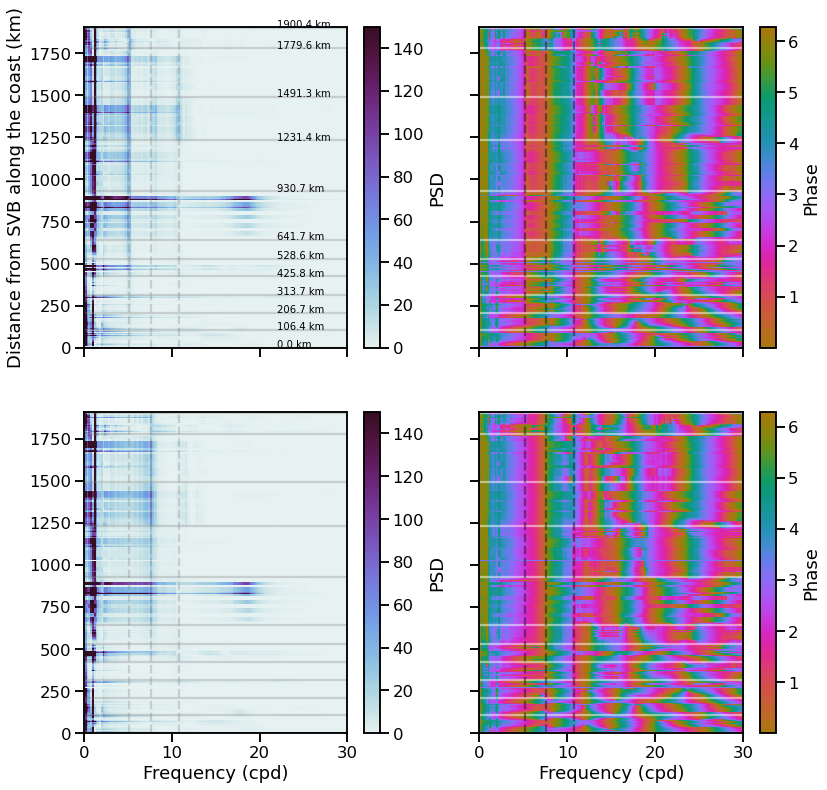

In [16]:
fig,((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(13,13), sharey=True, sharex=True)

ax3.set_xlabel('Frequency (cpd)')
ax1.set_ylabel('Distance from SVB along the coast (km)')
pc1 = ax1.pcolormesh(f_SVB*86400,X, (psd_sig_SVB), cmap=cmo.cm.dense, vmin=0, vmax=150)
plt.colorbar(pc1,ax=ax1, label='PSD')

pc3 = ax3.pcolormesh(f_NoSVB*86400,X, (psd_sig_NoSVB), cmap=cmo.cm.dense, vmin=0, vmax=150)
plt.colorbar(pc3,ax=ax3, label='PSD')

pc2 = ax2.pcolormesh(fftFreq_SVB*86400,X, phase_SVB+np.pi, cmap=cmo.cm.phase)
plt.colorbar(pc2,ax=ax2, label='Phase')
ax2.set_xlim(0,30)

ax4.set_xlabel('Frequency (cpd)')
pc4 = ax4.pcolormesh(fftFreq_noSVB*86400,X, phase_noSVB+np.pi, cmap=cmo.cm.phase)
plt.colorbar(pc2,ax=ax4, label='Phase')
ax4.set_xlim(0,30)

for kk in range(nx):
    if kk%50 == 0:
        ax1.axhline(X[kk],color='0.5',alpha=0.3)
        ax1.text(22,X[kk],'%1.1f km' %X[kk], fontsize=10)
        ax2.axhline(X[kk],color='w',alpha=0.5)
        ax3.axhline(X[kk],color='0.5',alpha=0.3)
        ax4.axhline(X[kk],color='w',alpha=0.5)

ax1.axvline(5.2, color='0.5', linestyle='--',alpha=0.3)
ax1.axvline(7.6, color='0.5', linestyle='--',alpha=0.3)
ax1.axvline(10.8, color='0.5', linestyle='--',alpha=0.3)
ax2.axvline(5.2, color='0.1', linestyle='--',alpha=0.5)
ax2.axvline(7.6, color='0.1', linestyle='--',alpha=0.5)
ax2.axvline(10.8, color='0.1', linestyle='--',alpha=0.5)

ax3.axvline(5.2, color='0.5', linestyle='--',alpha=0.3)
ax3.axvline(7.6, color='0.5', linestyle='--',alpha=0.3)
ax3.axvline(10.8, color='0.5', linestyle='--',alpha=0.3)
ax4.axvline(5.2, color='0.1', linestyle='--',alpha=0.5)
ax4.axvline(7.6, color='0.1', linestyle='--',alpha=0.5)
ax4.axvline(10.8, color='0.1', linestyle='--',alpha=0.5)

(2.0, 20.0)

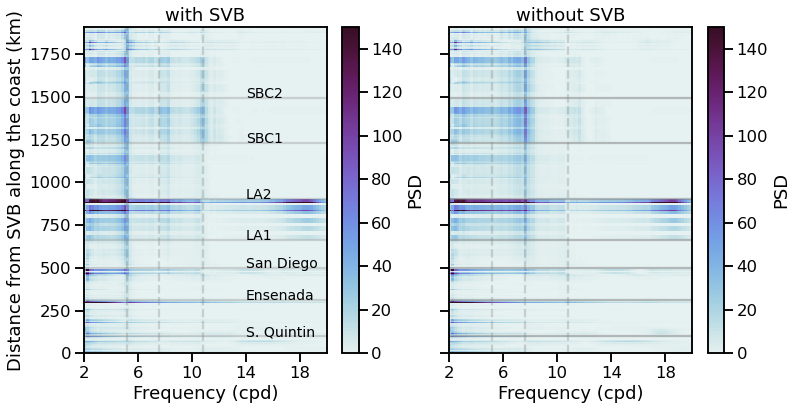

In [17]:
sns.set_context('talk')
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(12,6), sharey=True, sharex=True)

ax2.set_xlabel('Frequency (cpd)')
ax1.set_xlabel('Frequency (cpd)')
ax1.set_ylabel('Distance from SVB along the coast (km)')
pc1 = ax1.pcolormesh(f_SVB*86400,X, (psd_sig_SVB), cmap=cmo.cm.dense, vmin=0, vmax=150)
plt.colorbar(pc1,ax=ax1, label='PSD')

pc2 = ax2.pcolormesh(f_NoSVB*86400,X, (psd_sig_NoSVB), cmap=cmo.cm.dense, vmin=0, vmax=150)
plt.colorbar(pc2,ax=ax2, label='PSD')

for km, lab in zip([101,313.7,500, 660, 900, 1231, 1492], ['S. Quintin','Ensenada','San Diego','LA1','LA2','SBC1', 'SBC2']):
    ax1.axhline(km,color='0.5',alpha=0.3)
    ax1.text(14,km,lab, fontsize=14)
    ax2.axhline(km,color='0.5',alpha=0.5)

ax1.set_title('with SVB')
ax2.set_title('without SVB')
ax1.axvline(5.2, color='0.5', linestyle='--',alpha=0.3)
ax1.axvline(7.6, color='0.5', linestyle='--',alpha=0.3)
ax1.axvline(10.8, color='0.5', linestyle='--',alpha=0.3)
ax2.axvline(5.2, color='0.5', linestyle='--',alpha=0.3)
ax2.axvline(7.6, color='0.5', linestyle='--',alpha=0.3)
ax2.axvline(10.8, color='0.5', linestyle='--',alpha=0.3)

ax1.set_xticks([2,6,10,14,18])
ax1.set_xlim(2,20)

In [18]:
filename = 'curtain_SSH_spectra_NoSVB_bottDrag.nc'
description = 'spectra of SSH data at points along the coast to build curtain hovmöller plot no SVB with bottom drag'
title = 'spectra of SSH curtain plot data bottDrag no SVB'
create_nc_file(X, f_NoSVB*86400, psd_sig_NoSVB, phase_noSVB+np.pi, filename,
               title, description)